# RL Notes 4: Temporal Difference Methods

The cleaned-up blog post is [here](https://krisztiankovacs.com/rl-notes-4-temporal-differences/)

One drawback of the MC methods covered [last week](https://krisztiankovacs.com/reinforcement_learning/2018/09/30/rl-notes-3-exporation-vs-exploitation.html) is that they need to simulate complete episodes of an environment (start to finish) before updating our policy. That's fine if individual episodes are short. However, usually we don't want to wait until the end of an episode to update our policy. Also, some environments are continuous.

Why not update the policy as we go through the task? That's the essence of temporal difference methods (TD). TD is to Monte Carlo what stochastic gradient descent is to batch gradient descent. Update after each round, don't wait until the end. One TD method is Q-learning. It is really simple, but is often described in an overcomplicated way.

Reminder: the Q function is a mapping that gives the value of state-action combinations. To obtain the best action in a state, look up the maximum Q value in that state (among available actions).

We start with randomly initializing Q. After every action, we update it according to:

$$Q(s_t, a_t) = (1 - \alpha)Q(s_t, a_t) + \alpha (r_t + \gamma * \max_{a} Q(s_{t+1}, a) ) $$

Or, equivalently:

$$Q(s_t, a_t) = Q(s_t, a_t) + \alpha (r_t + \gamma * \max_{a} Q(s_{t+1}, a)  - Q(s_t, a_t)) $$

where
- $Q(., .)$ is the value of an action in a given state,
- $\alpha$ is the learning rate (how quickly we update values,
- $r_t$ is the immediate reward at time *t*,
- $\gamma$ is the discount factor

In English: after every action we update our Q function. We update it with the immediate reward, plus the discounted value of the best action in the next time-step.

The learning rate controls to what degree we update vs. keep the old value. A learning rate of 0 means no updating at all, a learning rate of 1 means perfect replacement. We don't want perfect replacement, as the reward can be stochastic.

One trick: we should decrease the learning rate over time. The more often we take an action in a given state, the more certain we are about its reward distribution. In the example below, I apply the following learning rate schedule:
$$\alpha_{t} = \frac{\alpha_0}{1 + \alpha_{taper} * count(s_t, a_t)}$$

where $count(s, a)$ gives the number of times the agent did action *a* in state *s*. The hyper-parameters $\alpha_0$ and $\alpha_{taper}$ give the initial learning rate, and how fast I taper it to 0.

## Cheating Roulette again

I'm going to use the same [cheating roulette](https://github.com/kk1694/rl_course/blob/master/rl_notes_3.ipynb) environment as last week. 

In [ ]:
#!pip install pyglet==1.2.4
#!pip install gym

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import gym

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

In [3]:
gym.make('Roulette-v0')  # Openai's original roulette

<TimeLimit<RouletteEnv<Roulette-v0>>>

In [4]:
class CheatingRoulette(gym.envs.toy_text.RouletteEnv):
    '''A modification of the original openai Roulette environment. 
    Here, 0 has positive expected value.'''
    def step(self, action):
        assert self.action_space.contains(action)
        if action == self.n - 1:
            # observation, reward, done, info
            return 0, 0, True, {}

        if np.random.rand() < 0.033:  # Implement cheating
            val = 0
        else:     
            val = self.np_random.randint(1, self.n - 1)
        if val == action == 0:
            reward = self.n - 2.0
        elif val != 0 and action != 0 and val % 2 == action % 2:
            reward = 1.0
        else:
            reward = -1.0
        return 0, reward, False, {}

In [5]:
ENV = CheatingRoulette()
GAMMA = 0.99  
SIMS = 10000 # Number of simulations

In [6]:
class Policy(object):
    '''This class is a container for the different policies.
    
    Note: In roulette, states don't matter (and in the openai case, there is
    only 1 state). I still index relevant quantities by state though (for
    example, the Q function), so that this code can easily be extended for other
    environments.
    '''    
    
    def pi(self):
        '''Each policy will have to define this function'''
        raise NotImplementedError
    
    def __init__(self, lr_taper = 1e-4):
        self.env = ENV
        self.resetAll()
        self.lr_taper = lr_taper
            
    def next_action(self):
        '''Perform the next action according to policy. Update variables.'''
        self.old_state = self.state
        self.action = self.pi()
        self.action_list[self.episode].append(self.action)
        self.state_action_count[self.old_state, self.action] += 1
        self.state, self.reward, self.done, _ = self.env.step(self.action)
        self.current_total += self.reward
        self.callOnActionEnd()
        
    def playGame(self):
        '''Plays roulette for 100 rounds. This will be considered 1 game.'''
        self.resetGame()        
        for i in range(100):  # play 100 rounds
            self.current_round += 1
            self.next_action()
            if self.done:
                break
        self.callOnEnd()
        self.episode += 1
        
    def simPolicy(self, n = 10000):
        '''Plays n games of roulette, outputs a list of total rewards.'''
        res = []
        for i in range(n):
            if i % 1000 == 0:
                print('.', end = '')
            self.playGame()
            res.append(self.current_total)
        print('\n')
        return np.array(res)
        
    def resetAll(self):
        '''Reset all variables to default, thereby clearing game history.'''
        self.nA = self.env.action_space.n  # Number of actions
        self.nS = self.env.observation_space.n  # Number of states. For roulette, 1.
        self.episode = 0  # Number of games played (each with 100 rounds)
        self.state_action_count = np.zeros((self.nS, self.nA))
        self.Q = 2*np.random.rand(self.nS, self.nA) - 1  # Between -1 and 1
        self.action_list = []
        self.resetGame()
        self.lr = 0.01
    
    def resetGame(self):
        '''Resets a single game (but doesn't delete information from game history)'''
        self.state = self.env.reset()
        self.reward = 0
        self.current_round = 0
        self.current_total = 0
        self.done = False
        self.action_list.append([])
        
    def callOnEnd(self):
        '''Optional function that is executed at the end of each game.
        Usually related to updating strategy.'''
        pass
    
    def callOnActionEnd(self):
        '''Optional function that is executed at the end of each action step.'''
        self.updateQ_TD()  
        
    def getMaxQ(self):
        '''Returns action with the highest average Q value (highest average return)'''
        return np.argmax(self.Q[self.state, :])
    
    def updateQ_TD(self):
        lr = self.lr / (1 + self.lr_taper * self.state_action_count[self.old_state, self.action])
        disc_future_R = GAMMA*self.Q[self.state, self.getMaxQ()]
        if self.done:
            disc_future_R = 0
        td_error = self.reward + disc_future_R - self.Q[self.old_state, self.action]
        self.Q[self.old_state, self.action] += lr*td_error

In [7]:
def plotRun(res, title = 'Title', k=5, plot_avg = False):
    x = list(range(len(res)))
    run_avg = list(res[:(k-1)]) + [np.mean(res[i:(i+5)]) for i in range(len(res)-k+1)]
    fig = plt.figure(figsize = (10, 5))
    plt.scatter(x, res, marker = '.')
    if plot_avg: plt.plot(x, run_avg, color = 'black')   
    plt.title(f'Average Profit per Game: {np.mean(res)}')
    plt.suptitle(title)
    
def getResults(pol, title, sims = SIMS):
    res = pol.simPolicy(sims)
    plotRun(res, title)
    
def plotActions(pol, ints = [[0, 1000], [9000, 10000]]):
    legend = [f'Round {sub[0]} - {sub[1]}' for sub in ints]
    l0 = [item for sublist in pol.action_list[ints[0][0]:ints[0][1]] for item in sublist]
    l1 = [item for sublist in pol.action_list[ints[1][0]:ints[1][1]] for item in sublist]
    labels = [legend[0]]*len(l0) + [legend[1]]*len(l1)
    df = pd.DataFrame({'Actions':l0+l1, 'Round':labels})
    print('Actions taken by agent in different rounds')
    axes = df.hist('Actions', by = 'Round', layout = (1, 3), figsize = (15, 3), bins = pol.nA)
    plt.show()

In [8]:
class EpsGreedy(Policy):
    
    def __init__(self, k):
        super().__init__()
        self.k = k
    
    def pi(self):
        epsilon = self.k / max(self.episode, 1)
        if np.random.rand() <= epsilon:
            return self.env.action_space.sample()  # Do exploration
        else:
            return self.getMaxQ()  # Do exploitation

I'll only implement the *$\epsilon$-greedy* policy, but the other ones are easy to adopt as well.

..........



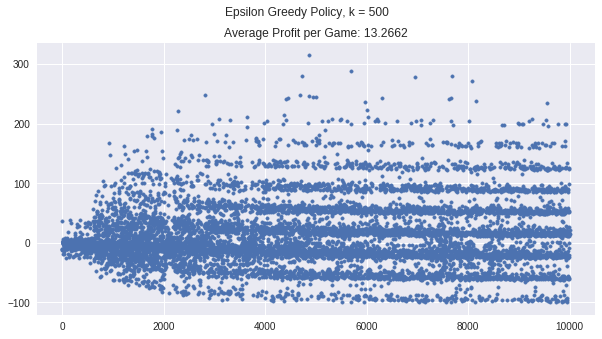

In [9]:
pol = EpsGreedy(500)
getResults(pol, "Epsilon Greedy Policy, k = 500")

Actions taken by agent in different rounds


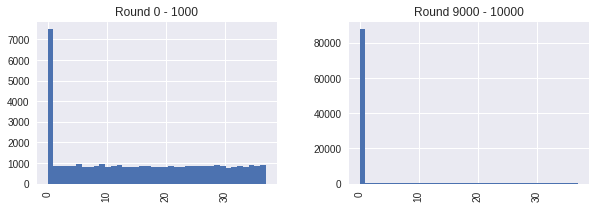

In [10]:
plotActions(pol)

The agent learns remarkably fast. That's no surprise, as we update after each action instead of waiting for the end of the episode.